# Problem Set 7

Iris Lan

In [174]:
import math, kplr
from my_transit import *
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.integrate import quad
%matplotlib inline

In [96]:
# Find the target KOI.
client = kplr.API()
koi = client.koi(97.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Open the first dataset and read it
file = lcs[0].open()
hdu_data = file[1].data
time = hdu_data["time"]  # get the time of each observation
flux = hdu_data["sap_flux"] # get the flux
ferr = hdu_data["sap_flux_err"] # get the error in the flux
file.close()

# store data in a table
KOI = Table([time, flux, ferr], names = ('time', 'flux', 'ferr'))
# KOI.show_in_notebook()

## Problem 1

extract the data in the time range 124 < t < 125

In [97]:
eidx = np.intersect1d(np.where(time <= 125.0), np.where(time >= 124.0))
time = time[eidx]
flux = flux[eidx]
ferr = ferr[eidx]

get $\overline{F}^\prime,\overline{\sigma}^\prime $

In [125]:
def normalize(f, n):
    
    def two_sigma_clipping(flux):
        F_p, sigma_p = np.mean(flux), np.std(flux)
        idx = np.where(abs(flux - F_p) / sigma_p <= 2)
        return flux[idx]
    
    i = 0
    while i < n:
#         print(i)
        f = two_sigma_clipping(f)
        i += 1
    
    return np.mean(f), np.std(f)

normalize flux and error with $\overline{F}^\prime,\overline{\sigma}^\prime $

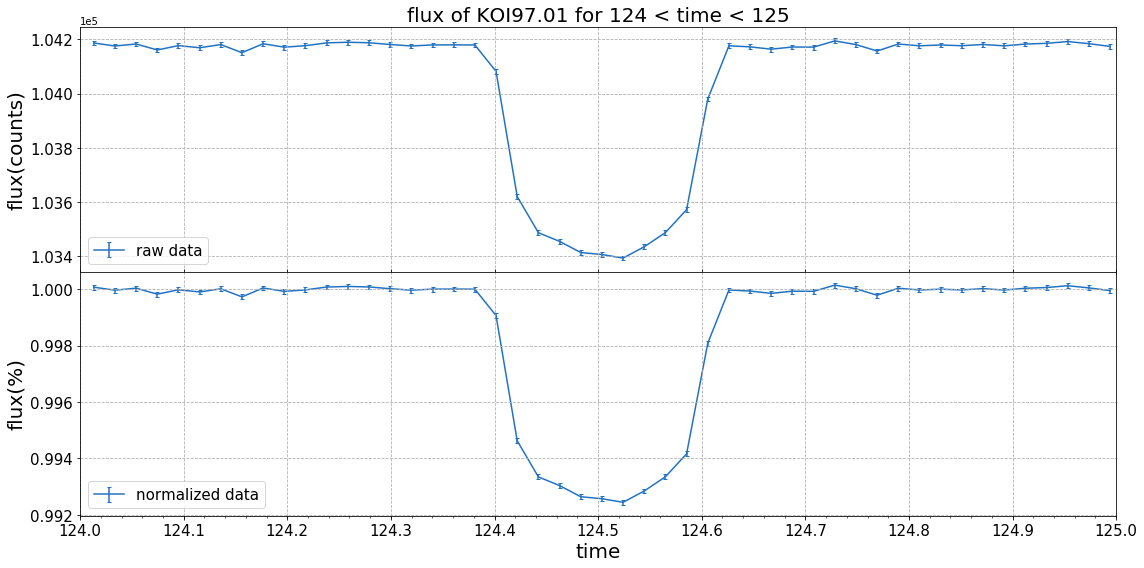

In [192]:
F_p, sigma_p = normalize(flux, 5)
nflux, nerr = flux / F_p, ferr / F_p

fig1, (axu, axb) = plt.subplots(2, 1, sharex = True, sharey = False, figsize = (16, 8))

axu.errorbar(time, flux, yerr = ferr, 
             fmt = '-', capsize = 2, c = '#2172C3', label = 'raw data', zorder = 1)
axb.errorbar(time, nflux, yerr = nerr, 
             fmt = '-', capsize = 2, c = '#2172C3', label = 'normalized data', zorder = 1)

for ax in (axu, axb):
    ax.grid(ls = '--')
    ax.legend(loc = 3, fontsize = 15)
    ax.tick_params(axis = 'both', labelsize = 15)
    
axu.tick_params(axis = 'x', direction = 'in')
axu.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0, 0), fontsize = 15)
axu.set_ylabel('flux(counts)', size = 20)
axu.set_title('flux of KOI97.01 for 124 < time < 125', fontsize = 20)

axb.set_xlim(124.0, 125.0)
axb.set_xlabel('time', size = 20)
axb.xaxis.set_major_locator(MultipleLocator(0.1))
axb.xaxis.set_minor_locator(MultipleLocator(0.02))
axb.set_ylabel('flux(%)', size = 20)

fig1.tight_layout()
fig1.subplots_adjust(hspace = 0.0)

define all the functions

In [181]:
def z_func(t, t_0, tau):
    '''convert time to z'''
    return (t - t_0) / tau
z_func = np.vectorize(z_func)

def func1(r, p, z):
    '''the numerator'''
    return I(r) * (1 - delta(p,r,abs(z))) * 2 * r

def func2(r, p, z):
    '''the denominator'''
    return I(r) * 2 * r

def I(r):
    '''A Limb-darkening functionm, r = sin(theta)'''
    mu = (1 - (r**2))**(0.5)
    return 1 - (1 - (mu**(0.5)))

def Flux(p, z, **kwargs):
    return quad(func1, a = 0.0, b = 1.0, args = (p, z))[0] / quad(func2, a = 0.0, b = 1.0, args = (p, z))[0]
Flux = np.vectorize(Flux)

def chi_square(y, fit, sigma):
    return np.sum(((y - fit) / sigma)**2)

fit the light curve with $p = 0.0775, t_0 = 124.51, \tau = 0.1$ and compute the $\chi^2$

In [182]:
fit1 = Flux(p = 0.0775, z = z(time, t_0 = 124.51, tau = 0.1))
chi2_1 = chi_square(nflux, fit1, nerr)
print('chi2 = %.4f' % chi2_1)

chi2 = 465.1987


## Problem 2

plot the data and the predicted transit curve

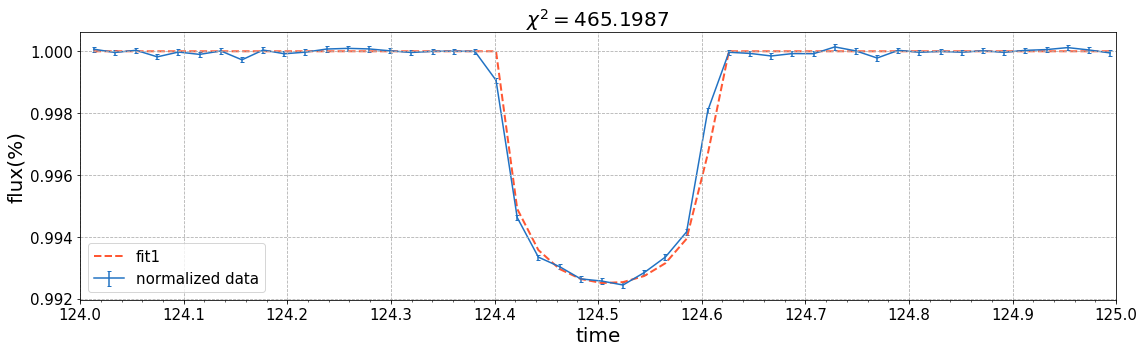

In [201]:
fig2, ax2 = plt.subplots(figsize = (16, 5))

ax2.errorbar(time, nflux, yerr = nerr, 
             fmt = '-', capsize = 2, c = '#2172C3', label = 'normalized data', zorder = 1)
ax2.plot(time, fit1, 
             ls = '--', lw = 2, c = '#FF5733', label = 'fit1', zorder = 1)

ax2.set_xlim(124.0, 125.0)
ax2.tick_params(axis = 'both', labelsize = 15)
ax2.xaxis.set_major_locator(MultipleLocator(0.1))
ax2.xaxis.set_minor_locator(MultipleLocator(0.02))
ax2.set_xlabel('time', size = 20)
ax2.set_ylabel('flux(%)', size = 20)
ax2.set_title('$\chi^2 = %.4f$' % chi2_1, fontsize = 20)
ax2.grid(ls = '--')
ax2.legend(loc = 3, fontsize = 15)

fig2.tight_layout()
fig2.subplots_adjust(hspace = 0.0)

The fit looks pretty good by eyes

In [176]:
def pvalue(a, x):
    def gamma(t, a):
        return np.exp(-t) * t**(a - 1)
    
    return quad(gamma, a = x, b = np.inf, args = (a,))[0] / quad(gamma, a = 0.0, b = np.inf, args = (a,))[0]

In [180]:
print('the p value is %.3e' % pvalue((len(nflux) - 3) / 2, chi2_1 / 2))

the p value is 1.099e-70


The P value suggests that our fit is not good enough

## Problem 3

vary $\tau$ between 0.08 and 0.13, compute $\chi^2$ with $p = 0.0775, t_0 = 124.51$

In [196]:
chi2_list = []
tau_list = np.linspace(0.08, 0.13, 1000)
for tau in tau_list:
    fit = Flux(p = 0.0775, z = z(time, t_0 = 124.51, tau = tau))
    chi2_list.append(chi_square(nflux, fit, nerr))

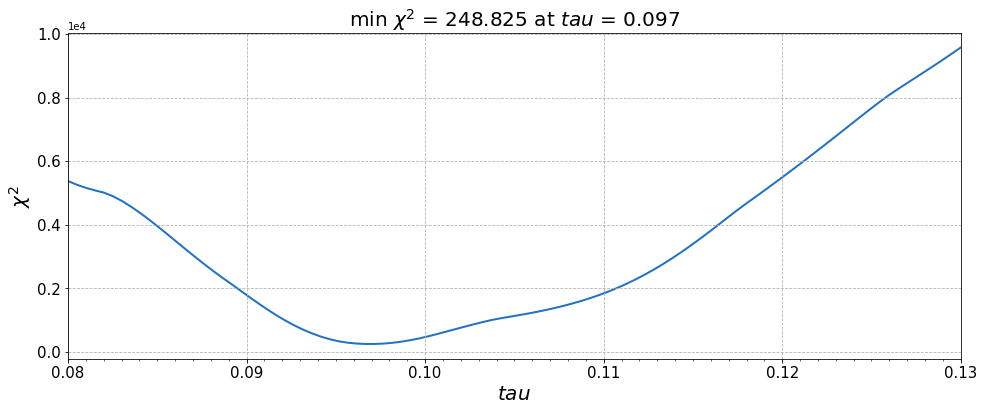

In [221]:
fig3, ax3 = plt.subplots(figsize = (16, 6))

ax3.plot(tau_list, chi2_list, ls = '-', lw = 2, c = '#2172C3', label = '$\chi^2$', zorder = 1)

ax3.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0, 0), fontsize = 15)
ax3.tick_params(axis = 'both', labelsize = 15)
ax3.set_xlim(0.08, 0.13)
ax3.set_xlabel('$\ttau$', size = 20)
ax3.set_ylabel('$\chi^2$', size = 20)
ax3.xaxis.set_major_locator(MultipleLocator(0.01))
ax3.xaxis.set_minor_locator(MultipleLocator(0.001))
ax3.set_title('min $\chi^2$ = %.3f at $\ttau$ = %.3f' % (np.min(chi2_list), tau_list[np.argmin(chi2_list)]), fontsize = 20)
ax3.grid(ls = '--')

fig2.tight_layout()
fig2.subplots_adjust(hspace = 0.0)

In [223]:
print('the corresponding p value is %.3e' % pvalue((len(nflux) - 3) / 2, np.min(chi2_list) / 2))

the corresponding p value is 1.225e-29
